# Face Mask Detection - NN Practical Course Exercise
在这个练习中，您的任务是构建一个分类器，它可以区分带口罩和不带口罩的人的图像。

[点击此处下载数据集！](https://drive.google.com/drive/folders/1EjGVyYL39cKyVbFeKvdq67_r0T39Nszp?usp=sharing)

它取自[Kaggle-Face Mask Detection Dataset](https://www.kaggle.com/wobotintelligence/face-mask-detection-dataset)，并且是一个相当大的数据集，因此您可能希望在GPU上运行。 训练和测试图像注释包括人脸的边界，因此您无需实现对象识别组件，只需实现分类器。
> he training and test image annotations include the bounding rect of the face, so you do not need to implement the object recognition component, only the classifier.

## 0.先决条件
+ 需要用到的库
+ 根据这个任务：只要两个类


In [1]:
import os
import numpy as np
import pandas as pd

from PIL import Image

import torch 
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms 
from tqdm import tqdm

## 绘图
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

# Set random seed for reproducibility
np.random.seed(0)

尽管提供的数据集包括各种不同的类，但本任务仅对`face_no_mask`和`face_with_mask`类(label)感兴趣。

In [2]:
# image calsses
classes = ['face_no_mask', 'face_with_mask']

# 将类字符串(class string) --> integer
def to_label(classname):
    # 首先assert 输入的classname 是存在的class，然后直接返回classname的idnex作为label 0/1
    assert classname in classes
    return classes.index(classname)

# 由label编号得到对应的类的名字
def to_classname(label):
    assert 0 <= label < len(classes)
    return classes[label]

### 【新】读取数据库的 csv文件   
我们加载一个a pandas dataframe >>> 它包含face的关于`filenames`, `classes` and `bounding rectangles`的信息，我们可以抽看一个csv的数据：
```
name,x1,x2,y1,y2,classname
2756.png,69,126,294,392,face_with_mask
2756.png,505,10,723,283,face_with_mask
2756.png,75,252,264,390,mask_colorful
2756.png,521,136,711,277,mask_colorful
6098.jpg,360,85,728,653,face_no_mask
6427.png,218,98,577,580,face_with_mask_incorrect
```
+ 注意`classname`中class有很多

In [3]:
# change if needed 数据路径
data_path = r'C:\Users\123\Desktop\数据集仓库\口罩检测任务'

# 读取csv文件的到 panda数据结构中
# 由上面可以看到我们只需要 filter relevant rows
data = pd.read_csv(os.path.join(data_path, 'data.csv'))
# panda数据的filter/索引
data = data[data.classname.isin(classes)]
data = data.reset_index(drop=True)
print(data)

          name   x1   x2   y1   y2       classname
0     2756.png   69  126  294  392  face_with_mask
1     2756.png  505   10  723  283  face_with_mask
2     6098.jpg  360   85  728  653    face_no_mask
3     4591.png  239    9  522  342  face_with_mask
4     5525.jpg  262   18  484  319    face_no_mask
...        ...  ...  ...  ...  ...             ...
5744  4149.png  399   71  718  581  face_with_mask
5745  3389.png  101    2  435  456  face_with_mask
5746  2460.png  650    5  805  184    face_no_mask
5747  1894.jpg  437  121  907  644  face_with_mask
5748  3216.png  126   69  409  463  face_with_mask

[5749 rows x 6 columns]


这里我们不是**一次性将所有图像加载到内存中**，而是创建一个Torch数据集(a Torch dataset)。这允许我们按需lazy-load图像，并动态应用有用的转换(例如预处理)。

### 自定义数据集 有关csv的dataframe

In [4]:
# 自定义 dataset for lazy-load images
#
class FaceDataset(Dataset):
    """
    写文本说明
    Args:
        dataframe : 是pandas读取的数据的csv信息
        img_dir (string): Directory with all the images.
        transform (callable, optional): Optional transform to be applied on a sample.
    """
    def __init__(self, dataframe, img_dir, transform = (lambda x : x)):
        self.df = dataframe
        self.transform = transform
        self.img_dir = img_dir
        
    def __len__(self):
        return len(self.df)
    
    # 如果在类中定义了__getitem__()方法，那么其实例对象dataset的（假设为P）
    # 就可以这样P[key]取值。当实例对象做P[key]运算时，就会调用类中的__getitem__(key)方法
    # 需要注意的是 数据在生成实例的时候一般会指定transform 注意辨析
    
    def __getitem__(self, idx):
        """
        Args:
            index (int): Index

        Returns:
            tuple: (image, label) where image is class_index of the label class.
        """
        name, x1, x2, y1, y2, classname = self.df.iloc[idx]
        
        img_path = os.path.join(self.img_dir, name)
        image = Image.open(img_path)
        #image = plt.imread(img_path)
        label = to_label(classname)
        
        #返回 矩形坐标的数组
        
        rect = np.array([(x1, x2), (y1, y2)])
        # 对img做transform时，rect也要同时变换，如果没有rect就不用这一步
        sample = {
            'image': image, #PILimage
            'rect': rect
        }
        if self.transform:
            sample = self.transform(sample)
        # 得到image和其所属的label
        return sample, label
        

+ 没有 `train=True` 参数，读入的数据集就是完成的数据集，后面再分割
+ 如果要实现直接生成valid数据集的目标，可以参考 dogs-vs-cats笔记中 一个小问题中的那篇文章   

加载试试，有没有完成既定目标：
+ 目标是 lazy-load 数据集：！！把读取图片的函数写在`__getitem__`中没有在猫狗自定义数据集那种写法出现的溢出问题？

In [5]:
# 测试，没有定义transform
# data_path = r'C:\Users\123\Desktop\数据集仓库\口罩检测任务'
img_dir = os.path.join(data_path, 'images')
full_dataset = FaceDataset(dataframe=data, img_dir=img_dir)

In [6]:
def plot_image(img, rect = None, title = None) :
    fig, ax = plt.subplots(1)
    ax.imshow(img)

    # Plot bounding rectangle
    if rect is not None :
        ax.add_patch(patches.Rectangle(
            rect[0],
            rect[1][0] - rect[0][0],
            rect[1][1] - rect[0][1],
            fill = False,
            linewidth = 2,
            color = 'r'))

    # Display title and plot image
    if title :
        plt.title(title)
    plt.axis('off')
    plt.show()

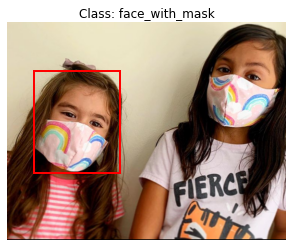

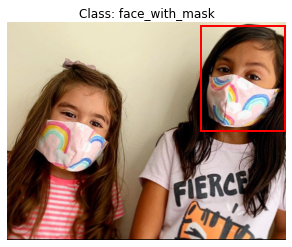

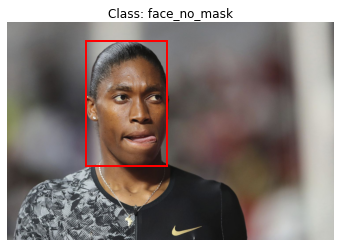

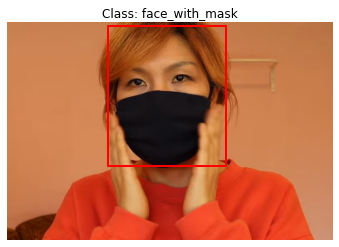

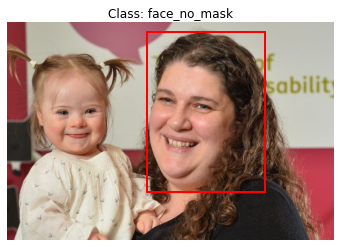

In [7]:
# Plot first 5 images
for i in range(5) :
    sample, label = full_dataset[i]
    plot_image(sample['image'], rect = sample['rect'], title = f'Class: {to_classname(label)}')

mark 如果没有 `transform = (lambda x : x)` (`transform=None`)就画不出 框

## 1. 创建训练数据
上面我们将全部的图片读入了一个数据集`full_dataset`.   
正如我们所看到的，数据集中的图像以及人脸 在size and resolution上都有所不同。为了在分类器的训练中使用它们，在调整大小和归一化(resizing and normalizing them)它们之前，我们将裁剪图像(crop the images)
+ 问题：不能使用transform中的crop吗？   

### 【新】自定义image的transform函数并添加到transforms.Compose()中

首先，让我们创建一个**被transform对象**，它接收一个 sample (image + bounding rectangle)  并返回一个裁剪过的(cropped)图像-- 由给定的bounding rectangle "cutting out" the face   

+ 注意：参数`sample` 是字典类型，其结构和内容在FaceDataset类的`__getitem__`方法中进行了描述 
```python
sample = {
            'image': image,
            'rect': rect
        }
```

In [8]:
class RectCrop(object):
    
    def __call__(self, sample):
        # 获取x1，x2, y1, y2的坐标
        #(left, top), (right, bottom) = sample['rect']
        # 这样按照数组那样切片大概是不行的，因为我的 sample['image'] 是使用PIL读取的
        # cropped = sample['image'][top:bottom, left:right]
        # 是用PIL库的crop函数
        bounding_box = sample['rect'].reshape(4,)
        cropped = sample['image'].crop(bounding_box)
        return cropped

---
探究：
经过`print(sample['rect'])` 得到的输出是(2,2)  (<class 'numpy.ndarray'>)
```python
[[ 69 126]
 [294 392]] 
```
于是我们想要得到这个值使用   
```python
(left, top, right, bottom) = sample['rect']
```
会出错    
+ 解决办法1 将这个ndarray化成1维向量
  `(left, top, right, bottom) = sample['rect'].reshape(4,)`
  
+ 解决办法2 二维赋值
  `(left, top), (right, bottom) = sample['rect']`
  再把这个些值unpack即可
  `bounding_box = (left, top, right, bottom)`   
  
  ---

现在我们有了自定义的裁剪变换(cropping transform)，我们可以将其与其他预处理变换(pytorch自带的)一起使用，来为image samples创建预处理的pipeline。 为了简单起见，我们可以使用Compose类来组成以下转换：
- `RectCrop` to crop the faces
- `ToTensor` to convert images (NumPy arrays) to Torch tensors
- `Resize` to get a uniform image size of 60 x 50
- `Grayscale` to remove RGB color information
- `Normalize` to normalize mean and variance to 0 and 1

In [9]:
transform = transforms.Compose([
    RectCrop(),
    transforms.ToTensor(),
    transforms.Resize((60, 50)),
    transforms.Grayscale(),
    
    # 灰度
    transforms.Normalize((0,), (1,))
])
# 读取为训练(未分割的完全数据)
# data_path = r'C:\Users\123\Desktop\数据集仓库\口罩检测任务'
img_dir = os.path.join(data_path, 'images')
dataset = FaceDataset(dataframe=data, img_dir=img_dir, transform=transform)

+ 仍然存在的疑问是定义FaceDataset时候的`transform`的默认参数--如果不输出查看图像设置为`transform=None`这种通用写法也没有问题？

让我们看一看裁剪和标准化的图像。

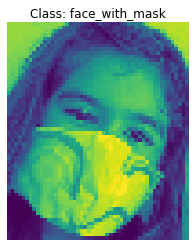

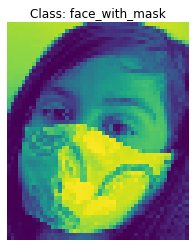

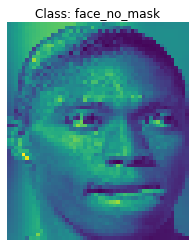

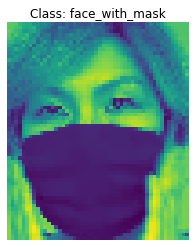

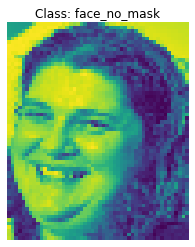

In [10]:
for i in range(5) :
    img, label = dataset[i]
    img = img.squeeze().numpy()
    plot_image(img, title = f'Class: {to_classname(label)}')

### 将数据集分割成 训练集+测试集
+ 现在我们有了合适的数据集形式（`dataset`），我们可以创建单独的训练和测试集

In [11]:
test_size = 0.1
# valid_size = 0.2

num_dataset = len(dataset)
indices_all = list(range(num_dataset))
np.random.shuffle(indices_all)
split_idx_test = np.int(np.floor(num_dataset * test_size))
train_idx, test_idx = indices_all[split_idx_test:], indices_all[:split_idx_test]

train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
test_sampler = torch.utils.data.SubsetRandomSampler(test_idx)
train_loader = torch.utils.data.DataLoader(dataset, batch_size=16, sampler=train_sampler)
test_loader = torch.utils.data.DataLoader(dataset, batch_size=16, sampler=test_sampler)

In [12]:
print(len(test_loader))

36


> 这种方法有一个问题就是不能/不会将训练集数据继续的划分为验证集的数据   
+ 下面是使用`torch.utils.data`中的`random_split`进行分割

In [13]:
test_size = 0.1

num_dataset = len(dataset)
number_of_test = np.int(num_dataset * test_size)
number_of_train = num_dataset - number_of_test
trainset, testset = torch.utils.data.random_split(dataset, (number_of_train, number_of_test))


# Create iterable dataloaders
trainloader = DataLoader(trainset, batch_size = 16, shuffle = True)
testloader  = DataLoader(testset,  batch_size = 16, shuffle = True)

In [14]:
print(len(testloader))

36


+ 有了 `trainset` 可以继续分validset

In [15]:
valid_size = 0.2
num_trainset = len(trainset)
num_of_valid = np.int(valid_size * num_trainset)
num_of_train = num_trainset - num_of_valid
trainset, validset = torch.utils.data.random_split(trainset, (num_of_train, num_of_valid))

# Create iterable dataloaders
trainloader = DataLoader(trainset, batch_size = 16, shuffle = True)
validloader  = DataLoader(testset,  batch_size = 16, shuffle = True)


In [16]:
print(len(trainloader)) # 按batch_size算的

259


## 2. 定义网络结构
一个简单的模型可能如下所示：

+ Convolutional layer w/ 64 filters
+ Max-Pooling layer
+ Convolutional layer w/ 32 filters
+ Max-Pooling layer
+ Fully connected layer w/ 64 output neurons
+ Dropout
+ Fully connected layer w/ 2 output neurons
+ Log-Softmax   

和ReLU作为激活功能。 您可以自由地尝试filter sizes, padding, stride, layer sizes, number of layers等，甚至可以自己实现更复杂的模型。

+ 输入的size是(60, 50)的灰度图--计算大小 `(W−F+2P)/S+1`
  + (60-3+2)/1 + 1=60, --> maxpool=30 --> 卷积结果一样大-->maxpool=15
  + (50-3+2)/1 + 1 = 50 --> 25 --> 12.5-->12

In [18]:
import torch.nn.functional as F
class MyConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 64, 3, padding=1, stride=1)
        self.conv2 = nn.Conv2d(64, 32, 3, 1, 1)
        self.maxpool = nn.MaxPool2d(2, 2)
        
        self.dropout = nn.Dropout(p=0.2)
        self.fc1 = nn.Linear(15*12*32, 64)
        self.fc2 = nn.Linear(64, 2)
        
        
    def forward(self, x):
        x = self.maxpool(F.relu(self.conv1(x)))
        x = self.maxpool(F.relu(self.conv2(x)))
        
        # flatten
        x = x.view(x.shape[0], -1)
        x = self.dropout(F.relu(self.fc1(x)))
        x = F.log_softmax(self.fc2(x))
        return x
        
model = MyConvNet()
print(model)

MyConvNet(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=5760, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=2, bias=True)
)


### 另一种定义网络的方法
```python
class CNN(nn.Module) :

    def __init__(self) :
        super().__init__()
        # Your code here
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 32, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        fc1_size = (img_size[0] // 2 // 2) * (img_size[1] // 2 // 2) * 32
        self.fc1 = nn.Sequential(
            nn.Linear(fc1_size, 64),
            nn.ReLU(),
            nn.Dropout(0.2)
        )
        self.fc2 = nn.Sequential(
            nn.Linear(64, len(classes)),
            nn.LogSoftmax(dim = 1)
        )
    
    def forward(self, x) :
        # Your code here
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.fc2(x)
        return x
```

## 3. 训练模型   
在开始训练例程之前，我们需要一个error criterion（例如，如果`nn.LogSoftmax是`最后一层的激活函数，则是`nn.NLLLoss`）和一个optimizer(e.g. Adam)。 它的参数的`lr`和 `weight_decay` 可以自由调节。

+ 设定损失函数核权重更新方法
+ 设置epochs, 循环epochs
 + 决定loss可视化的策略：
   + 每个epoch输出一个 train_loss, 输出一个 valid_loss，
   + 然后每个epoch都比较 valid_loss是否是最小valid_loss，若是保存当前模型为最优模型
+ 训练过程(遍历epoch，在每个epoch)：
 + **打开训练模式**
 + 从a batch of data中进行训练/学习的步骤：
 + 清除梯度信息
 + 前向计算输出
 + 比较输出和label计算loss
 + 反向计算梯度
 + 更新权重
 + 更新训练损失

In [19]:
criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
print(device)

cuda


其次，我们在小批量样本上定义单个训练步骤。 根据参数序列，我们希望我们的模型是否向后传播错误。 这样，我们也可以在以后的评估步骤中使用此功能。

+ 扩展：`Tqdm` 是一个快速，可扩展的Python进度条，可以在 Python 长循环中添加一个进度提示信息，用户只需要封装任意的迭代器 `tqdm(iterator)`。
+ 还有一个和`tqdm`类似的模块 `progressbar`

In [21]:
epochs = 20
for e in range(epochs):
    train_loss = 0
    valid_loss = 0
    model.train()
    for images, labels in tqdm(trainloader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        train_loss += loss.item() * images.size(0)
        
        loss.backward()
        optimizer.step()
        
    else:
        model.eval()
        with torch.no_grad():
            for images, labels in tqdm(validloader):
                images, labels = images.to(device), labels.to(device)
                log_ps = model(images)
                loss = criterion(log_ps, labels)
                valid_loss += loss.item() * images.size(0)
                
    train_loss = train_loss/len(trainloader)
    valid_loss = valid_loss/len(validloader)
    print('Epoch {}/{}..'.format(e+1, epochs), 
          'Train loss:{:.4f}..'.format(train_loss), 
          'Valid loss:{:.4f}..'.format(valid_loss))

  0%|▎                                                                                 | 1/259 [00:00<00:41,  6.27it/s]

Epoch 1/20.. Train loss:6.9255.. Valid loss:6.7427..


  0%|                                                                                          | 0/259 [00:00<?, ?it/s]

Epoch 2/20.. Train loss:6.4989.. Valid loss:6.0286..


  0%|▎                                                                                 | 1/259 [00:00<00:46,  5.54it/s]

Epoch 3/20.. Train loss:6.1489.. Valid loss:5.7735..


  0%|▎                                                                                 | 1/259 [00:00<00:50,  5.12it/s]

Epoch 4/20.. Train loss:5.5890.. Valid loss:5.3275..


  0%|                                                                                          | 0/259 [00:00<?, ?it/s]

Epoch 5/20.. Train loss:5.1708.. Valid loss:5.5872..


  0%|                                                                                          | 0/259 [00:00<?, ?it/s]

Epoch 6/20.. Train loss:4.7815.. Valid loss:6.7910..


  0%|                                                                                          | 0/259 [00:00<?, ?it/s]

Epoch 7/20.. Train loss:4.4115.. Valid loss:5.6952..


  0%|                                                                                          | 0/259 [00:00<?, ?it/s]

Epoch 8/20.. Train loss:4.0004.. Valid loss:5.1466..


  0%|                                                                                          | 0/259 [00:00<?, ?it/s]

Epoch 9/20.. Train loss:3.6491.. Valid loss:5.7039..


  0%|▎                                                                                 | 1/259 [00:00<00:46,  5.51it/s]

Epoch 10/20.. Train loss:3.5357.. Valid loss:5.5557..


  0%|▎                                                                                 | 1/259 [00:00<00:39,  6.51it/s]

Epoch 11/20.. Train loss:3.0589.. Valid loss:6.0708..


  0%|                                                                                          | 0/259 [00:00<?, ?it/s]

Epoch 12/20.. Train loss:2.7103.. Valid loss:5.6829..


  0%|                                                                                          | 0/259 [00:00<?, ?it/s]

Epoch 13/20.. Train loss:2.4517.. Valid loss:6.8417..


  0%|                                                                                          | 0/259 [00:00<?, ?it/s]

Epoch 14/20.. Train loss:2.2831.. Valid loss:6.2674..


  0%|▎                                                                                 | 1/259 [00:00<00:46,  5.60it/s]

Epoch 15/20.. Train loss:1.8881.. Valid loss:6.8128..


  0%|▎                                                                                 | 1/259 [00:00<00:39,  6.60it/s]

Epoch 16/20.. Train loss:1.7564.. Valid loss:6.8892..


  0%|                                                                                          | 0/259 [00:00<?, ?it/s]

Epoch 17/20.. Train loss:1.5610.. Valid loss:8.1430..


  0%|▎                                                                                 | 1/259 [00:00<00:38,  6.77it/s]

Epoch 18/20.. Train loss:1.3494.. Valid loss:8.6168..


  0%|▎                                                                                 | 1/259 [00:00<00:47,  5.42it/s]

Epoch 19/20.. Train loss:1.2777.. Valid loss:7.7261..


100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [00:07<00:00,  4.77it/s]

Epoch 20/20.. Train loss:1.2668.. Valid loss:8.3725..


+ 259是一个batch读取259张图片，一次16个batch
+ 进阶：在训练过程中保存网络参数字典/model

## 4. 评估网络
+ 因为没有保存最好的模型，所以这里的测试只是说明代码

作为最后一步，我们想看看我们的模型表现如何。 我们可以通过以类似的方式遍历我们尚未使用过的数据集`testloader`，同时累积测试损失和准确性来做到这一点。

对分类器的表现满意吗？ 如果没有，请尝试使用不同的超参数或CNN架构

Visualize Sample Test Results

C:\Users\123\anaconda3\envs\deep-learning\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


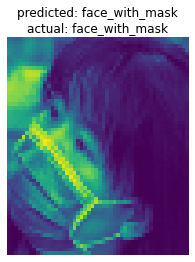

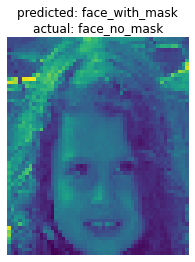

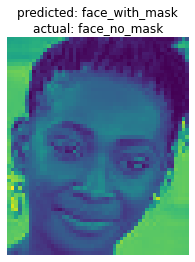

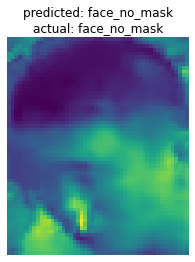

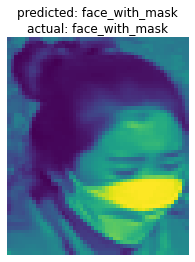

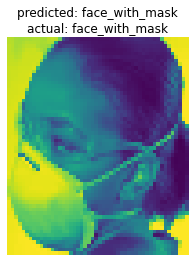

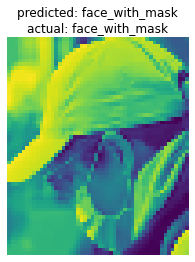

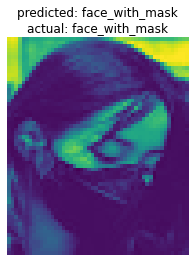

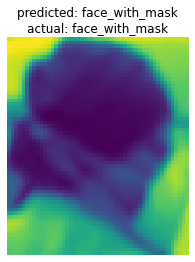

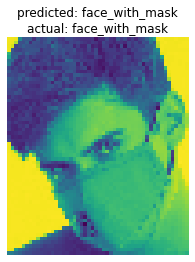

In [22]:
for i in range(10) :
    img, label = testset[i]
    pred = model(img.unsqueeze(0).to(device)).argmax(dim = 1).item()

    img = img.squeeze().numpy()
    title = f'predicted: {to_classname(pred)}\nactual: {to_classname(label)}'
    plot_image(img, title = title)